In [3]:
from pathlib import Path
import pyarrow.parquet as pq
import os
import yaml
import pandas as pd
from test_compliance import get_prediction_files, get_unit
import seaborn as sns
import seaborn.objects as so
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib
import cartopy.crs as ccrs
import requests
import mapclassify
from PIL import Image
import numpy as np

In [381]:
def prepare_geo_evaluation_data(submission, target, window = None):
    if target == "cm":
        unit = "country_id"
        shapefile_path = "shapefiles/countries.shp"
    elif target == "pgm":
        unit = "priogrid_gid"
        shapefile_path = "shapefiles/priogrid.shp"
    else:
        raise ValueError(f'Target must be "cm" or "pgm".')

    with open(submission/"submission_details.yml") as f:
        submission_details = yaml.safe_load(f)
        
    map = gpd.read_file(shapefile_path)
    if target == "pgm":
        map = map.rename(columns = {"priogrid_i": "priogrid_gid"}) # fix this in shapefile

    eval_file = submission / f"eval_{target}_per_unit.parquet"
    eval_df = pq.read_table(eval_file).to_pandas()
    eval_df = eval_df.reset_index()

    if window != None:
        eval_df = eval_df[eval_df["window"] == f"window=Y{window}"]

    df = pd.merge(eval_df, map, left_on = unit, right_on = unit)
    team = submission_details["team"]
    model = submission_details["even_shorter_identifier"]

    df = df.query(f'team == "{team}" and identifier == "{model}"')
    #df = df[df["team"] == submission_details["team"] and df["identifier"] == submission_details["even_shorter_identifier"]]
    df = gpd.GeoDataFrame(df)
    return df, eval_df, team, model

def choropleth_map_evaluation(submission, metric, target, window = None, cmap = "viridis", metric_ticks = None,  views_logo = True, info_box_placement = [0.66, 0.08, 0.1, 0.1]) -> None:
    if not isinstance(submission, Path):
        submission = Path(submission)
    
    pgm_map = gpd.read_file('shapefiles/priogrid.shp')
    cm_map = gpd.read_file('shapefiles/countries.shp')
        
    df, eval_df, team, model = prepare_geo_evaluation_data(submission, target = target, window = window)

    if metric == "crps" and target == "cm" and metric_ticks == None:
        drop_value = 1000
        metric_ticks = [0, 1, 10, 100, 500, 1000]
        
        vmin, vmax = df[metric].min(), drop_value
        cbar = plt.cm.ScalarMappable(norm = matplotlib.colors.SymLogNorm(linthresh = 10, vmin=vmin, vmax=vmax, base = 10), cmap = cmap)

    if metric == "ign" and target == "cm" and metric_ticks == None:
        drop_value = 10
        metric_ticks = [0, 2, 4, 6, 8, 10]
        
        vmin, vmax = df[metric].min(), drop_value
        cbar = plt.cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin=0, vmax=10, clip = True), cmap = cmap)

    if metric == "mis" and target == "cm" and metric_ticks == None:
        drop_value = 10000
        metric_ticks = [0, 10, 100, 1000, 5000, 10000]
        
        vmin, vmax = df[metric].min(), drop_value
        cbar = plt.cm.ScalarMappable(norm = matplotlib.colors.SymLogNorm(linthresh = 10, vmin=vmin, vmax=vmax, base = 10), cmap = cmap)

    if metric == "crps" and target == "pgm" and metric_ticks == None:
        drop_value = 100
        metric_ticks = [0, 1, 10, 30, 50, 100]
        
        vmin, vmax = df[metric].min(), drop_value
        cbar = plt.cm.ScalarMappable(norm = matplotlib.colors.SymLogNorm(linthresh = 10, vmin=vmin, vmax=vmax, base = 10), cmap = cmap)

    if metric == "ign" and target == "pgm" and metric_ticks == None:
        drop_value = 10
        metric_ticks = [0, 2, 4, 6, 8, 10]
        
        vmin, vmax = df[metric].min(), drop_value
        cbar = plt.cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin=0, vmax=10, clip = True), cmap = cmap)
    
    if metric == "mis" and target == "pgm" and metric_ticks == None:
        drop_value = 500
        metric_ticks = [0, 10, 100, 200, 500]
        
        vmin, vmax = df[metric].min(), drop_value
        cbar = plt.cm.ScalarMappable(norm = matplotlib.colors.SymLogNorm(linthresh = 10, vmin=vmin, vmax=vmax, base = 10), cmap = cmap)


    num_countries_dropped = (df[metric]>drop_value).sum()
    df[metric] = np.where(df[metric] > drop_value, drop_value, df[metric])

    sns.set_theme(style = "white")

    if target == "cm":
        crs = ccrs.EqualEarth()
        df = df.to_crs(crs.proj4_init + " +over")
    elif target == "pgm":
        crs = ccrs.PlateCarree()
        df = df.to_crs(pgm_map.crs)

    fig, ax = plt.subplots(figsize = (24, 8), subplot_kw = {"projection": crs})
    if target == "cm":
        ax.add_geometries(df["geometry"], crs = crs, facecolor = "none", edgecolor = "whitesmoke")
        ax.set_global()
    elif target == "pgm":
        cm_map.boundary.plot(ax=ax, linewidth=0.2)
        ax.set_extent([-20, 70, -40, 45])

    if views_logo:
        # Download and display the VIEWS logo image
        logo_url = "https://cdn.cloud.prio.org/images/c784369fb4ae42acb7ee882e91056d92.png?x=800&"
        response = requests.get(logo_url, stream=True)

        if response.status_code == 200:
            logo_img = Image.open(response.raw)
            if target == "cm":
                left = 0.2
            elif target == "pgm":
                left = 0.4
            logo_ax = fig.add_axes([left, 0.06, 0.1, 0.1])  # Define the position and size of the logo [left, bottom, width, height]
            logo_ax.imshow(logo_img)
            logo_ax.axis('off')  # Turn off axis labels and ticks for the logo
        else:
            print("Failed to download the logo image")

    df.plot(ax=ax, 
            column = metric,
            norm = matplotlib.colors.SymLogNorm(linthresh = 1),
            edgecolor = "#FF000000",
            cmap = cmap)

    fig.colorbar(cbar, ax=ax, 
                format = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')),
                label = metric.upper(),
                ticks = metric_ticks)
    
    if num_countries_dropped > 0:
        info_text = f'# countries truncated to {drop_value}: {num_countries_dropped}'
        if target == 'pgm':
            info_box_placement = [0.76, 0.08, 0.1, 0.1]
        ib_ax = fig.add_axes(info_box_placement)
        ib_ax.text(0, 0, info_text, ha = "left", fontstyle = "italic")
        ib_ax.axis('off')

    ax.gridlines(draw_labels=True, zorder = 0)
    # Title
    formatted_year = int(window)
    formatted_model = model.replace(team, '').strip().lstrip("_")
    formatted_team = team.replace("_", " ").strip().title()
    ax.set_title(f'Team: {formatted_team}, Model: {formatted_model}, Window: {formatted_year}', fontsize=16, pad = 20, loc = "left", fontweight = "bold")


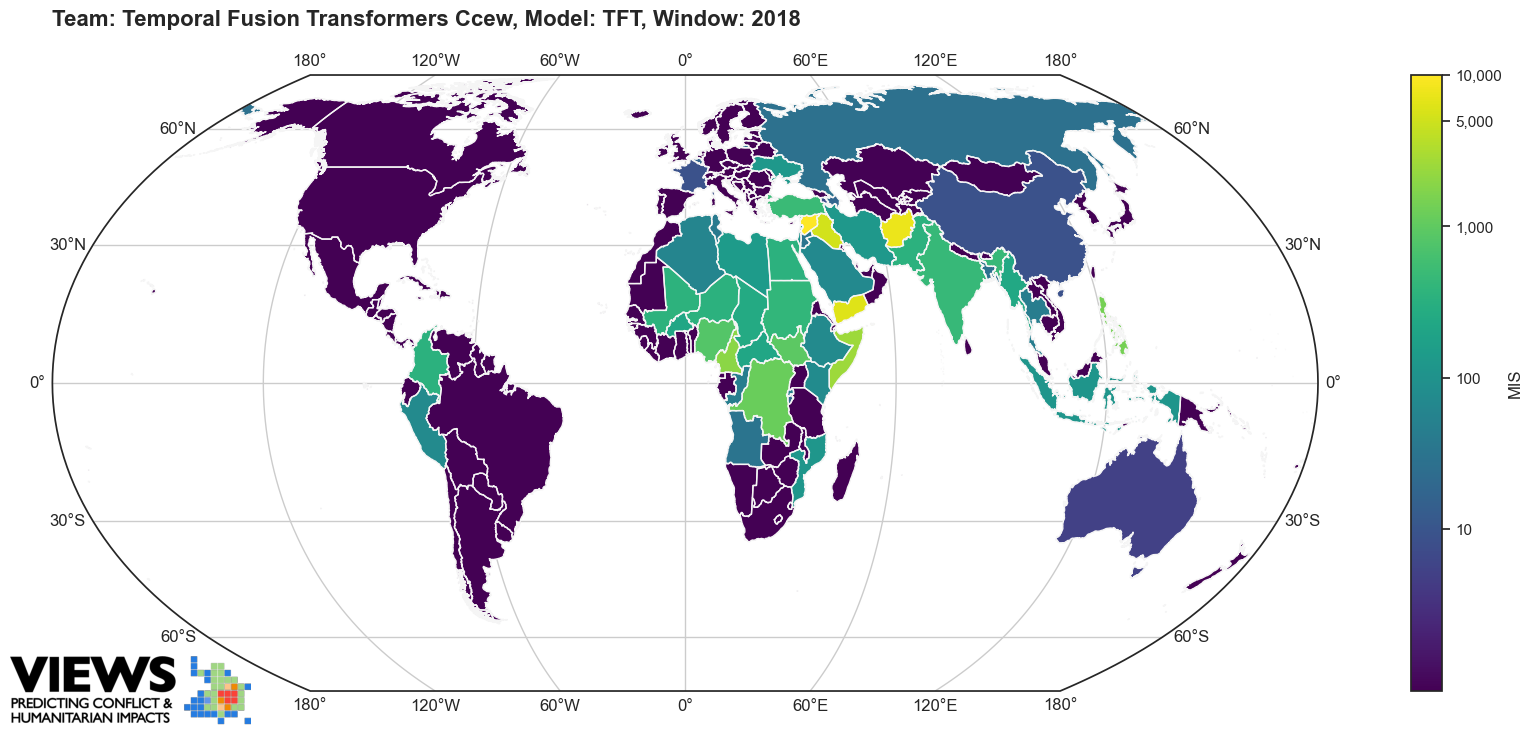

In [382]:
choropleth_map_evaluation(submission='final_submissions/submission_final', metric='mis', target='cm', window=2018)

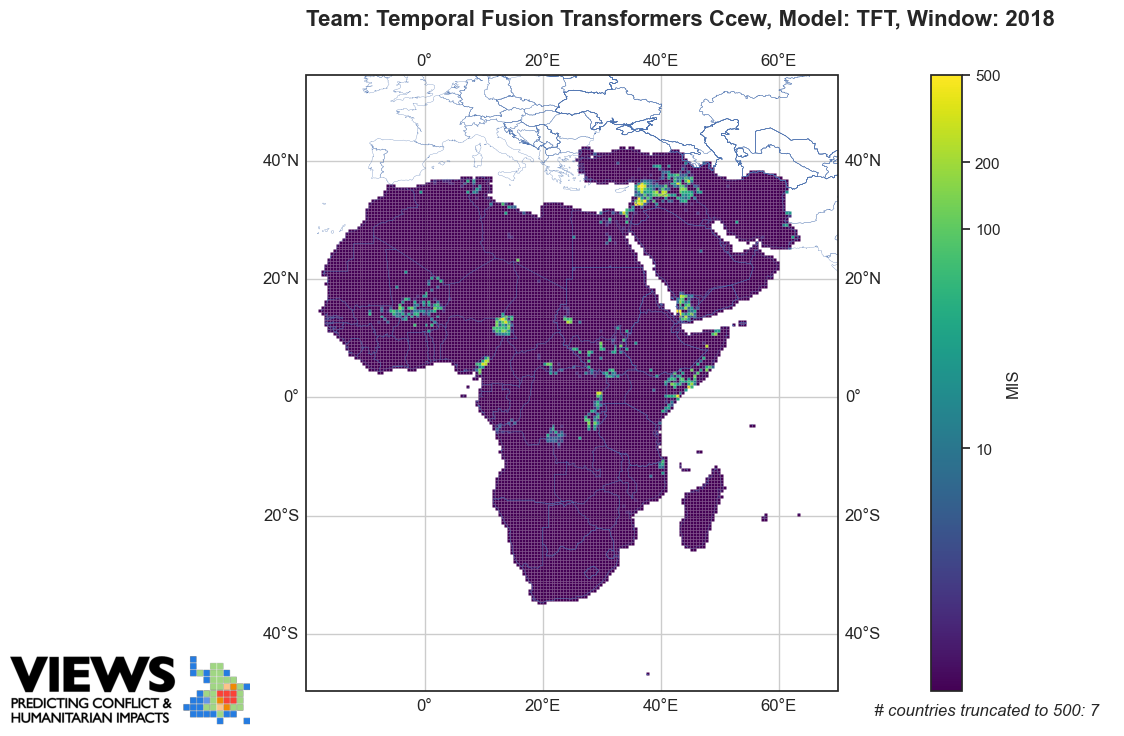

In [383]:
choropleth_map_evaluation(submission='final_submissions/submission_final', metric='mis', target='pgm', window=2018)

In [114]:
from pathlib import Path

# Define the directory path
directory_path = Path('final_submissions')

# Initialize dictionaries to store the thresholds
thresholds_cm = {}
thresholds_pgm = {}

# Iterate through the sub-directories
for sub_directory in directory_path.iterdir():
    if sub_directory.is_dir():
        # Extract the identifier from the sub-directory name
        identifier = sub_directory.name
        
        # Check if eval_cm_per_unit.parquet exists
        eval_cm_per_unit_file = sub_directory / 'eval_cm_per_unit.parquet'
        eval_pgm_per_unit_file = sub_directory / 'eval_pgm_per_unit.parquet'
        if eval_cm_per_unit_file.exists():
            # Prepare the geo data for cm
            df_cm, _, _, _ = prepare_geo_data(sub_directory, target='cm', shapefile='shapefiles/countries.shp')
            
            # Find the threshold where 99% of the values fall into for cm
            threshold_cm = {
                'crps': df_cm['crps'].quantile(0.99),
                'ign': df_cm['ign'].quantile(0.99),
                'mis': df_cm['mis'].quantile(0.99)
            }
            thresholds_cm[identifier] = threshold_cm
        
        if eval_pgm_per_unit_file.exists():
            # Prepare the geo data for pgm
            df_pgm, _, _, _ = prepare_geo_data(sub_directory, target='pgm', shapefile='shapefiles/priogrid.shp')
            
            # Find the threshold where 99.9% of the values fall into for pgm
            threshold_pgm = {
                'crps': df_pgm['crps'].quantile(0.999),
                'ign': df_pgm['ign'].quantile(0.999),
                'mis': df_pgm['mis'].quantile(0.999)
            }
            thresholds_pgm[identifier] = threshold_pgm
df_099_cm = pd.DataFrame(thresholds_cm).T
df_0999_pgm = pd.DataFrame(thresholds_pgm).T


In [110]:
df_099_cm

,crps,ign,mis
neg_binom_glmm,8.873847e+02,9.328096,1.486678e+04
submission_final_hpmm,6.854135e+02,4.456597,1.040300e+04
submission_bodentien_rueter,6.419653e+02,5.208098,1.062319e+04
tweedie_gam,1.632253e+03,9.814901,2.705576e+04
submission_final_gpcmm,1.020793e+03,9.981567,7.313543e+03
poisson_gam,1.000000e+09,9.981567,2.000000e+10
submission_template_becker_drauz_true_future,7.540331e+02,5.762499,1.208935e+04
submission_template,6.276718e+02,8.712853,6.800146e+03
poisson_glmm,9.748627e+02,9.922131,1.886563e+04
submission_muchlinski_thornhill,2.994242e+02,9.981567,5.988483e+03


In [115]:
df_0999_pgm

,crps,ign,mis
submission_prediction,26.900441,6.404035,350.619425
submission_calibrated,25.539806,6.469720,373.996833
unibw_trees_global,21.215070,3.848776,345.568333
submission_template 2,14.895484,6.760240,143.529254
unibw_trees_global-local,21.214756,3.852934,353.212083
dorazio2,22.845094,5.303710,418.539333
unibw_trees_local,21.099287,3.740877,366.408608
2024_06_conflictforecast,22.765162,4.069691,400.220372
submission_final,22.099072,5.253522,408.667593
dorazio1,21.916022,4.998077,425.250333


In [52]:
from pathlib import Path

# Define the directory path
directory_path = Path('final_submissions')

# Initialize dictionaries to store the maximum and minimum values
max_values_cm = {}
min_values_cm = {}
max_values_pgm = {}
min_values_pgm = {}

# Iterate through the sub-directories
for sub_directory in directory_path.iterdir():
    if sub_directory.is_dir():
        # Extract the identifier from the sub-directory name
        identifier = sub_directory.name
        
        # Check if eval_cm_per_unit.parquet exists
        eval_cm_per_unit_file = sub_directory / 'eval_cm_per_unit.parquet'
        eval_pgm_per_unit_file = sub_directory / 'eval_pgm_per_unit.parquet'
        if eval_cm_per_unit_file.exists():
            # Prepare the geo data for cm
            df_cm, _, _, _ = prepare_geo_data(sub_directory, target='cm', shapefile='shapefiles/countries.shp')
            
            # Find the maximum and minimum values for cm
            max_values_cm[identifier] = {
                'crps': df_cm['crps'].max(),
                'ign': df_cm['ign'].max(),
                'mis': df_cm['mis'].max()
            }
            min_values_cm[identifier] = {
                'crps': df_cm['crps'].min(),
                'ign': df_cm['ign'].min(),
                'mis': df_cm['mis'].min()
            }
        if eval_pgm_per_unit_file.exists():
            # Prepare the geo data for pgm
            df_pgm, _, _, _ = prepare_geo_data(sub_directory, target='pgm', shapefile='shapefiles/priogrid.shp')
            
            # Find the maximum and minimum values for pgm
            max_values_pgm[identifier] = {
                'crps': df_pgm['crps'].max(),
                'ign': df_pgm['ign'].max(),
                'mis': df_pgm['mis'].max()
            }
            min_values_pgm[identifier] = {
                'crps': df_pgm['crps'].min(),
                'ign': df_pgm['ign'].min(),
                'mis': df_pgm['mis'].min()
            }
df_max_values_cm = pd.DataFrame(max_values_cm).T
df_min_values_cm = pd.DataFrame(min_values_cm).T
df_max_values_pgm = pd.DataFrame(max_values_pgm).T
df_min_values_pgm = pd.DataFrame(min_values_pgm).T

In [53]:
df_max_values_cm

,crps,ign,mis
neg_binom_glmm,9.708332e+04,9.981567,1.607859e+06
submission_final_hpmm,1.328706e+04,9.113413,2.562783e+05
submission_bodentien_rueter,1.309384e+04,9.648234,2.351098e+05
tweedie_gam,7.431611e+08,9.981567,1.467277e+10
submission_final_gpcmm,1.335554e+04,9.981567,2.646100e+05
poisson_gam,1.000000e+09,9.981567,2.000000e+10
submission_template_becker_drauz_true_future,1.353985e+04,9.981567,2.662324e+05
submission_template,1.351947e+04,9.981567,2.685822e+05
poisson_glmm,7.182385e+04,9.981567,1.431438e+06
submission_muchlinski_thornhill,2.473413e+04,9.981567,4.946827e+05


In [61]:
df_max_values_pgm

,crps,ign,mis
submission_prediction,13116.992570,9.981567,261949.179167
submission_calibrated,13113.327871,9.981567,261954.925000
unibw_trees_global,13103.667969,8.686033,261968.562500
submission_template 2,62.037819,7.931972,871.289793
unibw_trees_global-local,13092.301210,8.602700,261900.208333
dorazio2,13109.295230,9.150965,262170.087500
unibw_trees_local,13097.827511,7.388114,261988.870833
2024_06_conflictforecast,12682.951171,9.153024,255592.008446
submission_final,13109.559607,9.265841,262183.383192
dorazio1,13109.185045,9.150965,262139.425000


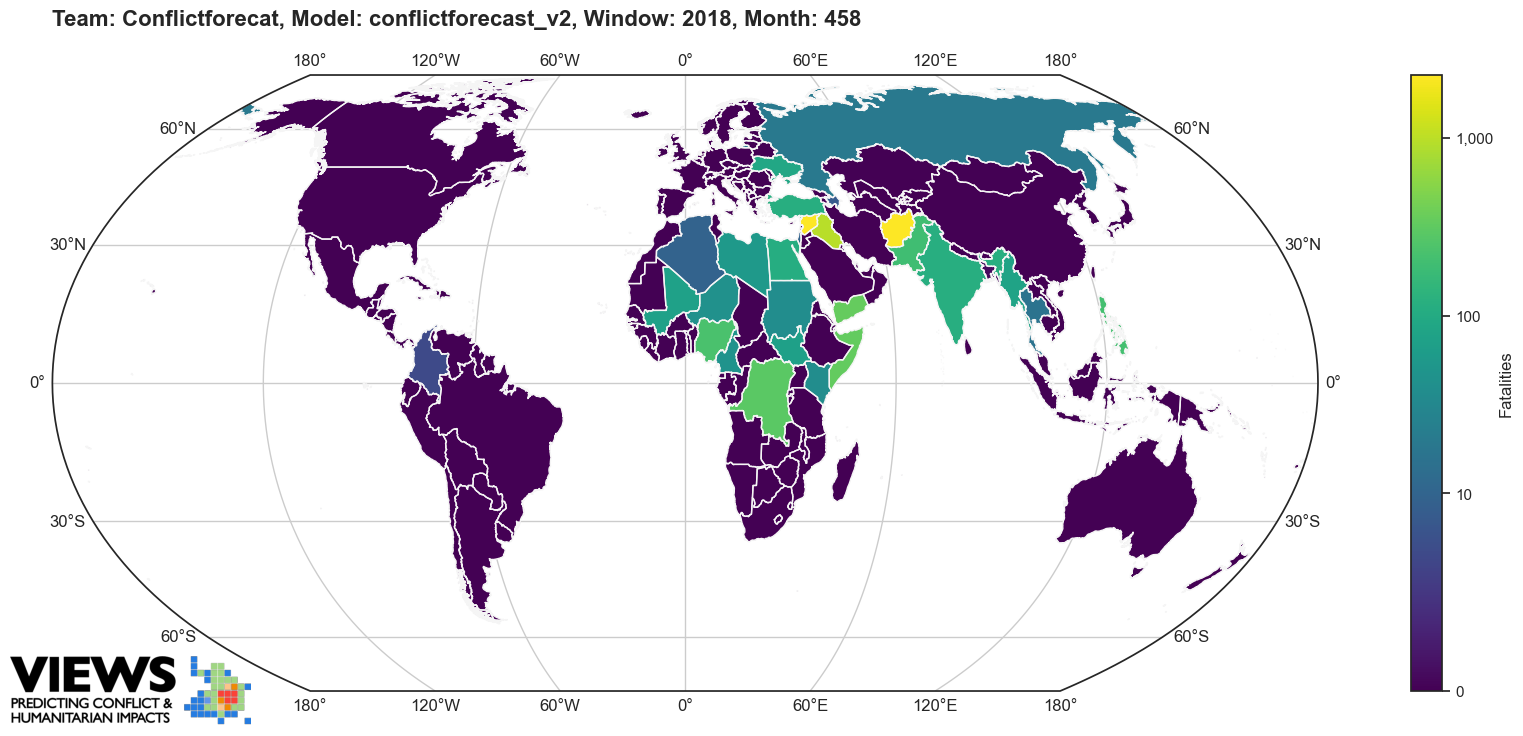

In [362]:
from plotting import choropleth_map_forecast
choropleth_map_forecast('final_submissions/2024_06_conflictforecast', 'cm', 2018, 458)

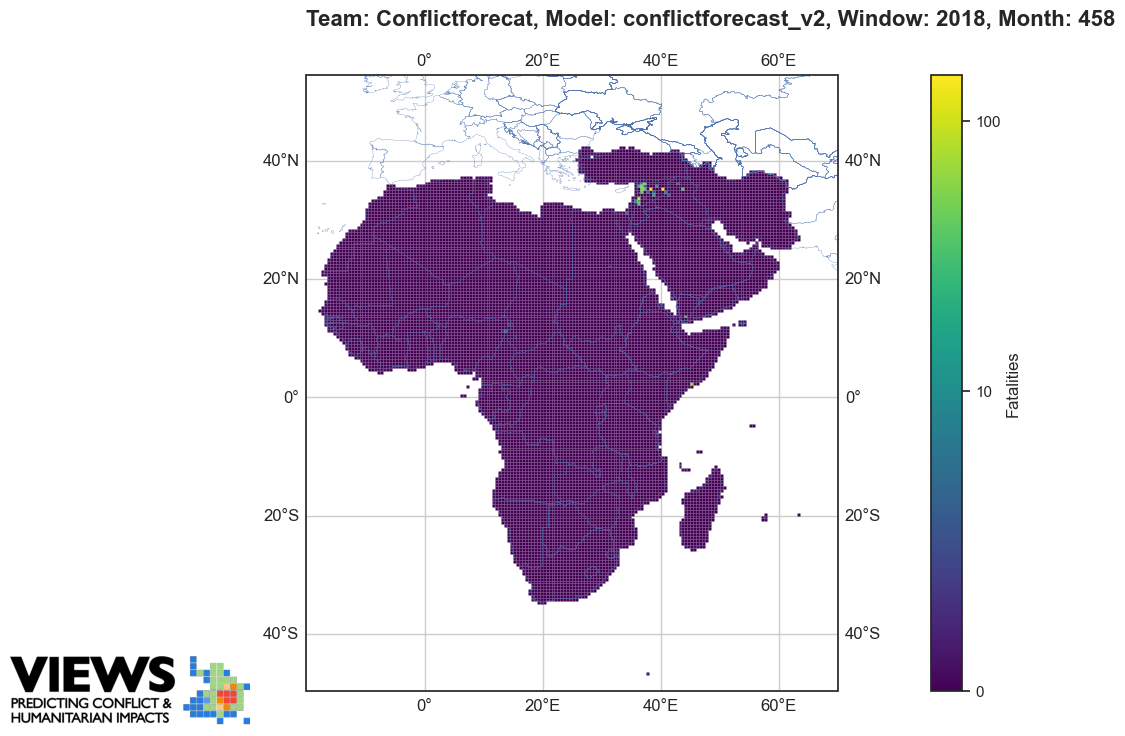

In [363]:
choropleth_map_forecast('final_submissions/2024_06_conflictforecast', 'pgm', 2018, 458)

In [ ]:
def choropleth_map_evaluation(submission, metric, target, shapefile, window = None, cmap = "viridis", metric_ticks = None, crs = ccrs.EqualEarth(), views_logo = True, info_box_placement = [0.66, 0.08, 0.1, 0.1]) -> None:
    df, eval_df, team, model = prepare_geo_data(submission, target = target, shapefile = shapefile, window = window)

    if metric == "crps" and target == "cm" and metric_ticks == None:
        drop_value = 1000
        metric_ticks = [0, 1, 10, 100, 500, 1000]
        
        vmin, vmax = df[metric].min(), drop_value
        cbar = plt.cm.ScalarMappable(norm = matplotlib.colors.SymLogNorm(linthresh = 10, vmin=vmin, vmax=vmax, base = 10), cmap = cmap)

    if metric == "ign" and target == "cm" and metric_ticks == None:
        drop_value = 4
        metric_ticks = [0, 1, 2, 3, 4]
        
        vmin, vmax = df[metric].min(), drop_value
        cbar = plt.cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin=0, vmax=4, clip = True), cmap = cmap)

    if metric == "crps" and target == "pgm" and metric_ticks == None:
        drop_value = 1000
        metric_ticks = [0, 1, 10, 100, 500, 1000]
        
        vmin, vmax = df[metric].min(), drop_value
        cbar = plt.cm.ScalarMappable(norm = matplotlib.colors.SymLogNorm(linthresh = 10, vmin=vmin, vmax=vmax, base = 10), cmap = cmap)

    if metric == "ign" and target == "pgm" and metric_ticks == None:
        drop_value = 4
        metric_ticks = [0, 1, 2, 3, 4]
        
        vmin, vmax = df[metric].min(), drop_value
        cbar = plt.cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin=0, vmax=4, clip = True), cmap = cmap)


    num_countries_dropped = (df[metric]>drop_value).sum()
    df[metric] = np.where(df[metric] > drop_value, drop_value, df[metric])

    sns.set_theme(style = "white")

    df = df.to_crs(crs.proj4_init + " +over")

    fig, ax = plt.subplots(figsize = (24, 8), subplot_kw = {"projection": crs})
    ax.gridlines(draw_labels=True, zorder = 0)
    ax.add_geometries(df["geometry"], crs = crs, facecolor = "none", edgecolor = "whitesmoke")
    ax.set_global()

    if views_logo:
        # Download and display the VIEWS logo image
        logo_url = "https://cdn.cloud.prio.org/images/c784369fb4ae42acb7ee882e91056d92.png?x=800&"
        response = requests.get(logo_url, stream=True)

        if response.status_code == 200:
            logo_img = Image.open(response.raw)
            logo_ax = fig.add_axes([0.2, 0.06, 0.1, 0.1])  # Define the position and size of the logo [left, bottom, width, height]
            logo_ax.imshow(logo_img)
            logo_ax.axis('off')  # Turn off axis labels and ticks for the logo
        else:
            print("Failed to download the logo image")


    df.plot(ax=ax, 
            column = metric,
            norm = matplotlib.colors.SymLogNorm(linthresh = 1),
            cmap = cmap)

    fig.colorbar(cbar, ax=ax, 
                format = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')),
                label = metric.upper(),
                ticks = metric_ticks)
    
    if num_countries_dropped > 0:
        info_text = f'# countries truncated to {drop_value}: {num_countries_dropped}'
        ib_ax = fig.add_axes(info_box_placement)
        ib_ax.text(0, 0, info_text, ha = "left", fontstyle = "italic")
        ib_ax.axis('off')

    # Title
    formatted_year = int(window.split("_")[-1])
    formatted_model = model.replace(team, '').strip().lstrip("_")
    formatted_team = team.replace("_", " ").strip().title()
    ax.set_title(f'Team: {formatted_team}, Model: {formatted_model}, Window: {formatted_year}', fontsize=16, pad = 20, loc = "left", fontweight = "bold")